In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, log_loss
from sklearn.preprocessing import label_binarize

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 254
CHANNELS = 3
EPOCHS = 85

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/New/Training2",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2800 files belonging to 8 classes.


In [4]:
# Menghitung jumlah gambar di setiap kelas
class_names = dataset.class_names
class_counts = {class_name: 0 for class_name in class_names}

for images, labels in dataset:
    for label in labels:
        class_name = class_names[label]
        class_counts[class_name] += 1

# Membuat DataFrame untuk menampilkan hasilnya
class_counts_df = pd.DataFrame(list(class_counts.items()), columns=['Kelas', 'Jumlah Citra'])
total_images = class_counts_df['Jumlah Citra'].sum()
total_row = pd.DataFrame([['<b>TOTAL</b>', '<b>2800</b>']], columns=class_counts_df.columns)
class_counts_df = pd.concat([class_counts_df, total_row], ignore_index=True)

# Membuat HTML untuk menampilkan tabel
class_counts_df_html = class_counts_df.to_html(index=False, escape=False)

# Menambahkan styling CSS
styled_html = """
<style>
    th {
        font-weight: bold;
    }
    tr:last-child {
        border-top: 2px solid black;
    }
</style>
""" + class_counts_df_html

# Menampilkan tabel
display(HTML(styled_html))

In [5]:
class_names = dataset.class_names
class_names

['Bacterial Leaf Blight',
 'Brown Spot',
 'Healthy Rice Leaf',
 'Leaf Blast',
 'Leaf Scald',
 'Narrow Brown Leaf Spot',
 'Rice Hispa',
 'Sheath Blight']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 254, 254, 3)
[3 2 5 3 7 6 3 5 4 6 0 6 6 5 0 4 3 0 6 5 7 0 6 4 7 5 4 6 1 1 6 7]


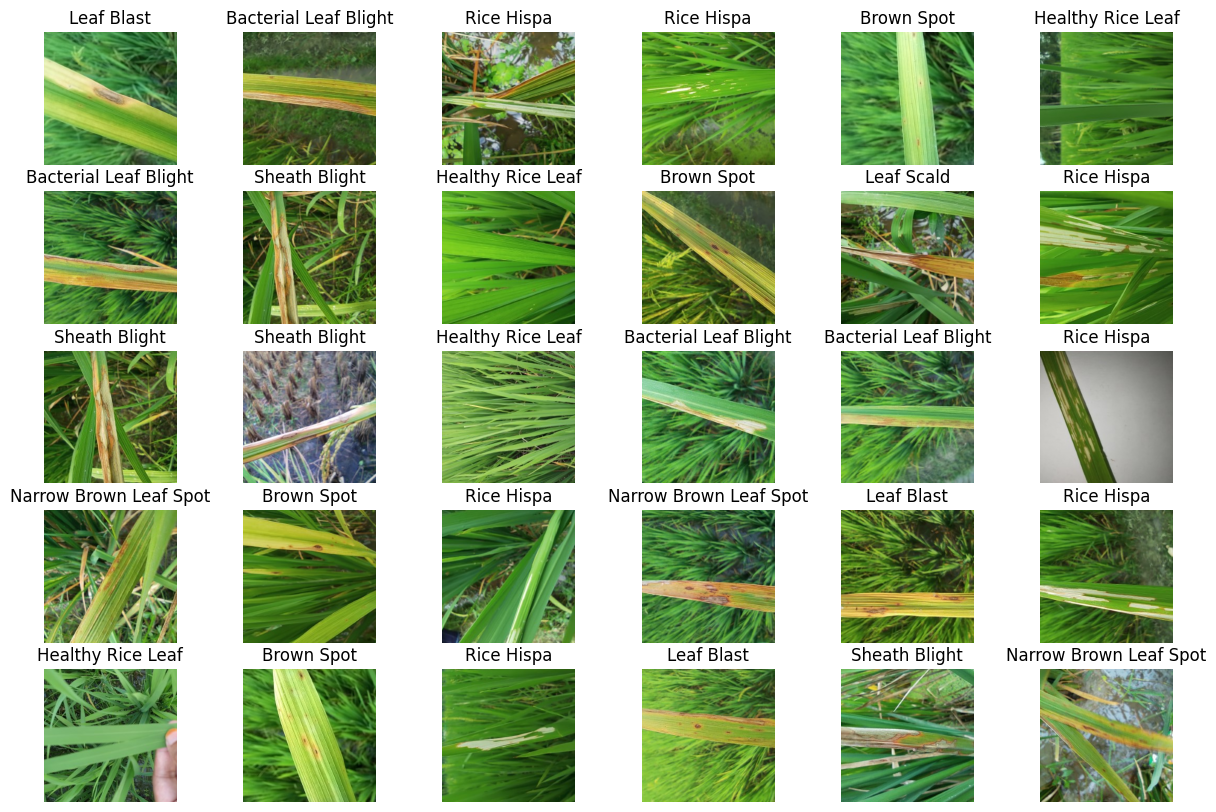

In [7]:
# Menampilkan sampel dataset
plt.figure(figsize=(15, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(30):
        ax = plt.subplot(5, 6, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
len(dataset)

88

In [9]:
train_size = 0.8
len(dataset)*train_size

70.4

In [10]:
train_ds = dataset.take(70)
len(train_ds)

70

In [11]:
test_ds = dataset.skip(70)
len(test_ds)

18

In [12]:
val_size=0.1
len(dataset)*val_size

8.8

In [13]:
val_ds = test_ds.take(8)
len(val_ds)

8

In [14]:
test_ds = test_ds.skip(8)
len(test_ds)

10

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(dataset)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = int(test_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

70

In [18]:
len(test_ds)

10

In [19]:
len(val_ds)

8

In [20]:
# Menghitung total batch
partition_counts = {
    'Pelatihan': len(train_ds),
    'Validasi': len(val_ds),
    'Pengujian': len(test_ds)
}
partition_counts_df = pd.DataFrame(list(partition_counts.items()), columns=['Partisi', 'Jumlah Batch'])
total_batch = len(train_ds) + len(val_ds) + len(test_ds)
total_row = pd.DataFrame([['<b>Total Batch</b>', f'<b>{total_batch}</b>']], columns=partition_counts_df.columns)
partition_counts_df = pd.concat([partition_counts_df, total_row], ignore_index=True)

# Membuat HTML untuk menampilkan tabel
partition_counts_df_html = partition_counts_df.to_html(index=False, escape=False)
partition_styled_html = """
<style>
    th {
        font-weight: bold;
    }
</style>
""" + partition_counts_df_html
display(HTML(partition_styled_html))

In [21]:
# Caching, shuffling, dan prefetching datasets
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
# Preprocessing
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Augmentasi
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2),
  layers.experimental.preprocessing.RandomContrast(0.2),
])

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
# Definisi model
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 8

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 254, 254, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 252, 252, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 126, 126, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 124, 124, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [25]:
# Callback untuk menyimpan model terbaik
checkpoint_filepath = './best_model_epoch_{epoch:02d}_val_acc_{val_accuracy:.2f}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/85


70/70 [==============================] - ETA: 0s - loss: 2.0380 - accuracy: 0.1794

C:\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


70/70 [==============================] - 122s 1s/step - loss: 2.0380 - accuracy: 0.1794 - val_loss: 1.9088 - val_accuracy: 0.2344
Epoch 2/85
70/70 [==============================] - 94s 1s/step - loss: 1.8814 - accuracy: 0.2464 - val_loss: 1.7603 - val_accuracy: 0.2812
Epoch 3/85
70/70 [==============================] - 92s 1s/step - loss: 1.7461 - accuracy: 0.3098 - val_loss: 1.7052 - val_accuracy: 0.3047
Epoch 4/85
70/70 [==============================] - 87s 1s/step - loss: 1.7080 - accuracy: 0.3008 - val_loss: 1.6863 - val_accuracy: 0.3047
Epoch 5/85
70/70 [==============================] - 91s 1s/step - loss: 1.5421 - accuracy: 0.3957 - val_loss: 1.3372 - val_accuracy: 0.4922
Epoch 6/85
70/70 [==============================] - 87s 1s/step - loss: 1.4911 - accuracy: 0.4384 - val_loss: 1.2439 - val_accuracy: 0.5312
Epoch 7/85
70/70 [==============================] - 86s 1s/step - loss: 1.4191 - accuracy: 0.4636 - val_loss: 1.1728 - val_accuracy: 0.5586
Epoch 8/85
70/70 [============

In [32]:
# Evaluasi model dengan data testing
model.load_weights('./best_model_epoch_75_val_acc_0.94.h5') # Ganti dg nama file asli best model
scores = model.evaluate(test_ds)
print(f"Test Loss: {scores[0]}, Test Accuracy: {scores[1]}")

10/10 [==============================] - 21s 430ms/step - loss: 0.3155 - accuracy: 0.9000
Test Loss: 0.31546443700790405, Test Accuracy: 0.8999999761581421


In [33]:
scores

[0.31546443700790405, 0.8999999761581421]

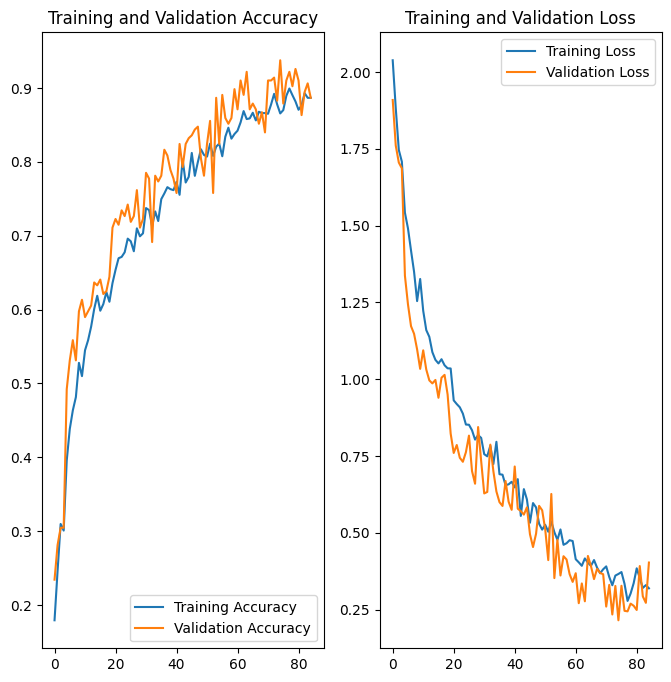

In [34]:
# Plotting Metriks Training dan Validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
# Evaluasi model menggunakan metrik tambahan
''' 
def preprocess_dataset(dataset):
    images = []
    labels = []
    for image_batch, label_batch in dataset:
        images.append(image_batch.numpy())
        labels.append(label_batch.numpy())
    images = np.concatenate(images)
    labels = np.concatenate(labels)
    return images, labels

X_test, y_test = preprocess_dataset(test_ds)
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_bin = label_binarize(y_test, classes=range(n_classes))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_bin, y_pred_probs, multi_class='ovr')
conf_matrix = confusion_matrix(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_probs)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print('Confusion Matrix:')
print(conf_matrix)
print(f'Log Loss: {log_loss_value:.4f}')

# Fungsi untuk plotting confusion matrix
def plot_confusion_matrix(cm, class_names):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot_confusion_matrix(conf_matrix, class_names)
plt.show() 
'''

' \ndef preprocess_dataset(dataset):\n    images = []\n    labels = []\n    for image_batch, label_batch in dataset:\n        images.append(image_batch.numpy())\n        labels.append(label_batch.numpy())\n    images = np.concatenate(images)\n    labels = np.concatenate(labels)\n    return images, labels\n\nX_test, y_test = preprocess_dataset(test_ds)\ny_pred_probs = model.predict(X_test)\ny_pred = np.argmax(y_pred_probs, axis=1)\ny_bin = label_binarize(y_test, classes=range(n_classes))\n\naccuracy = accuracy_score(y_test, y_pred)\nprecision = precision_score(y_test, y_pred, average=\'weighted\')\nrecall = recall_score(y_test, y_pred, average=\'weighted\')\nf1 = f1_score(y_test, y_pred, average=\'weighted\')\nroc_auc = roc_auc_score(y_bin, y_pred_probs, multi_class=\'ovr\')\nconf_matrix = confusion_matrix(y_test, y_pred)\nlog_loss_value = log_loss(y_test, y_pred_probs)\n\nprint(f\'Accuracy: {accuracy:.4f}\')\nprint(f\'Precision: {precision:.4f}\')\nprint(f\'Recall: {recall:.4f}\')\npri

In [37]:
#Prediksi class gambar dengan tingkat akurasi prediksi
def predict(model, image):
    image = np.expand_dims(image, axis=0)
    predictions = model.predict(image)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0]) * 100
    return predicted_class, confidence

1/1 [==============================] - 0s 54ms/step
Average Confidence: 89.30%
Correct Predictions: 89
Incorrect Predictions: 11


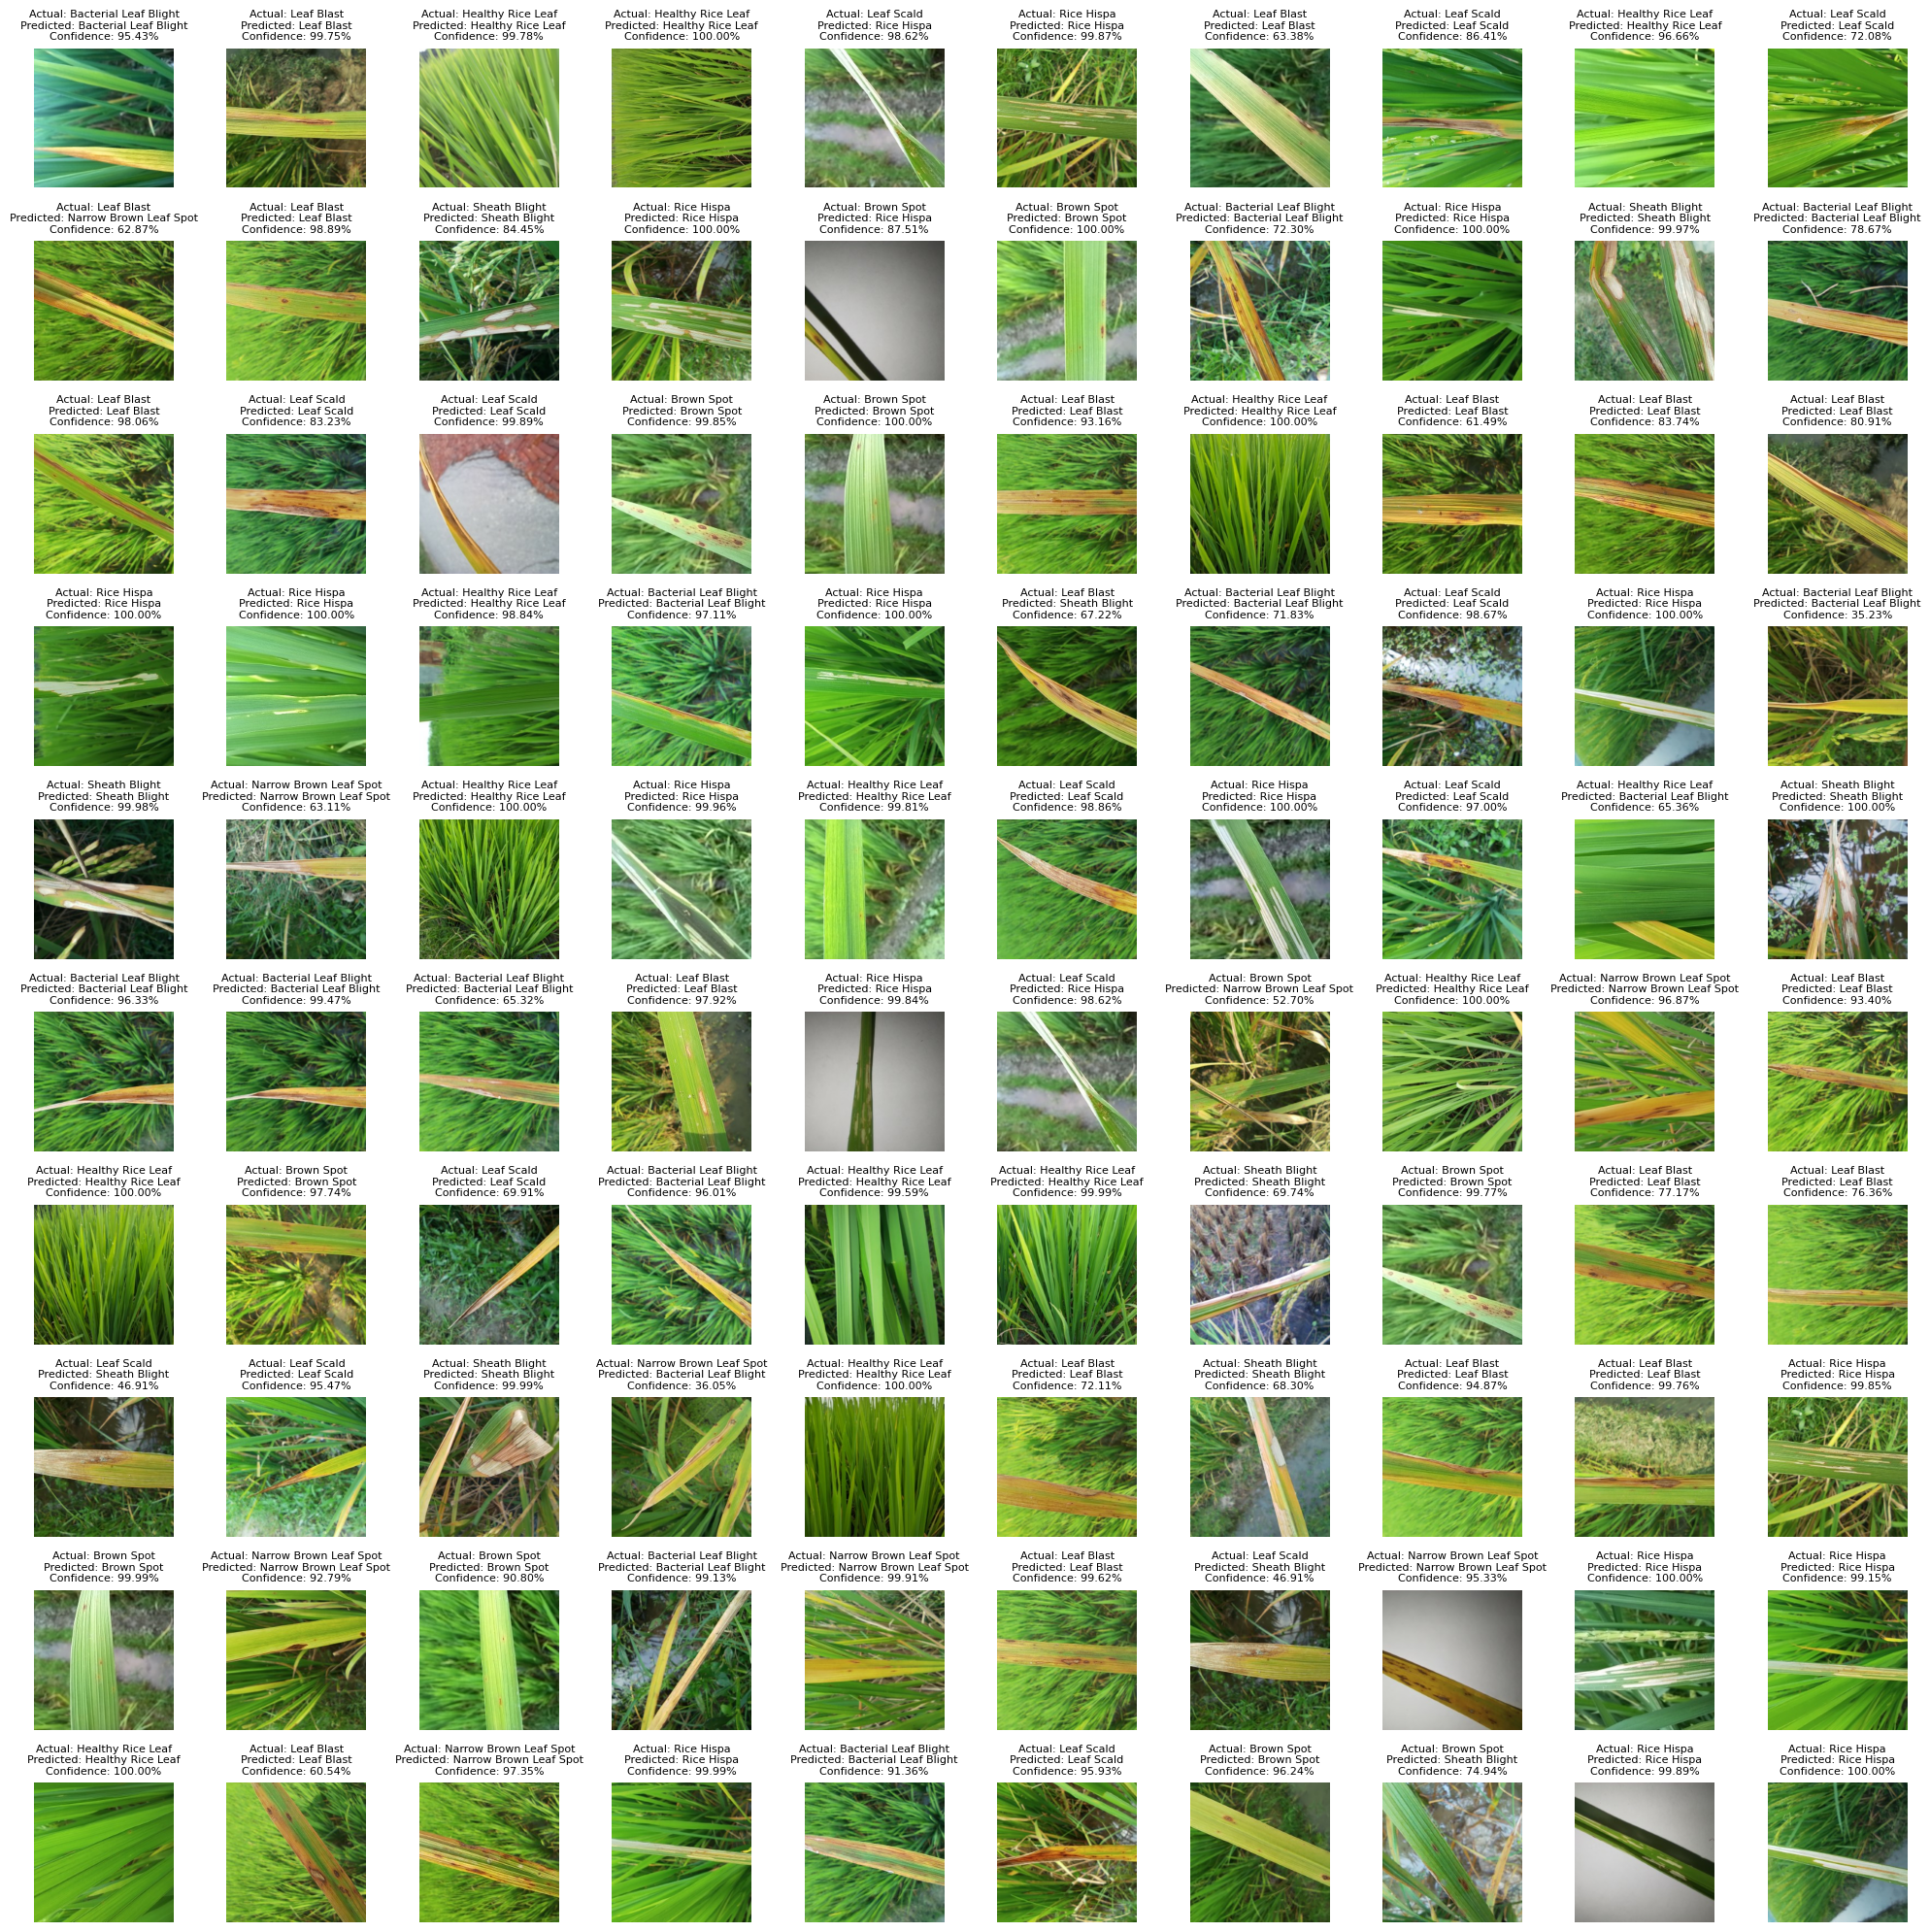

In [47]:
#Prediksi class gambar dengan tingkat akurasi prediksi
plt.figure(figsize=(20, 20))

confidences = []
correct_predictions = 0
incorrect_predictions = 0
images_processed = 0
max_images = 100

for images, labels in test_ds.take(4):
    num_images = min(len(images), max_images - images_processed)
    for i in range(num_images):
        ax = plt.subplot(10, 10, images_processed + i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        confidences.append(confidence)
        
        if predicted_class == actual_class:
            correct_predictions += 1
        else:
            incorrect_predictions += 1
        
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence:.2f}%", fontsize=8)
        plt.axis("off")
    
    images_processed += num_images
    if images_processed >= max_images:
        break

average_confidence = np.mean(confidences)
print(f"Average Confidence: {average_confidence:.2f}%")
print(f"Correct Predictions: {correct_predictions}")
print(f"Incorrect Predictions: {incorrect_predictions}")

plt.tight_layout()
plt.show()

In [40]:
import os
from keras.models import load_model

os.environ['HDF5_DISABLE_VERSION_CHECK'] = '1'
model_dir = "../Code/models"
model_files = [file for file in os.listdir(model_dir) if file.endswith('.h5')]
model_versions = [int(file.split('model')[1].split('.h5')[0]) for file in model_files]
model_version = max(model_versions + [0]) + 1

# Simpan model dalam format H5
best_model = load_model('./best_model_epoch_75_val_acc_0.94.h5')
best_model.save(f"{model_dir}/model{model_version}.h5")

# Untuk memuat kembali model
# loaded_model = load_model(f"{model_dir}/model{model_version}.h5")
